ConvBiLSTM and ConvBiGRU for next one day prediction

Epoch 1/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8883 - mae: 0.7976
Epoch 1: val_loss improved from inf to 0.59446, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.8776 - mae: 0.7915 - val_loss: 0.5945 - val_mae: 0.6036
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5135 - mae: 0.5603
Epoch 2: val_loss improved from 0.59446 to 0.42562, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.5120 - mae: 0.5594 - val_loss: 0.4256 - val_mae: 0.4956
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3672 - mae: 0.4665
Epoch 3: val_loss improved from 0.42562 to 0.38693, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3671 - mae: 0.4662 - val_loss: 0.3869 - val_mae: 0.4691
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3566 - mae: 0.4533 
Epoch 4: val_loss improved from 0.38693 to 0.36114, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━

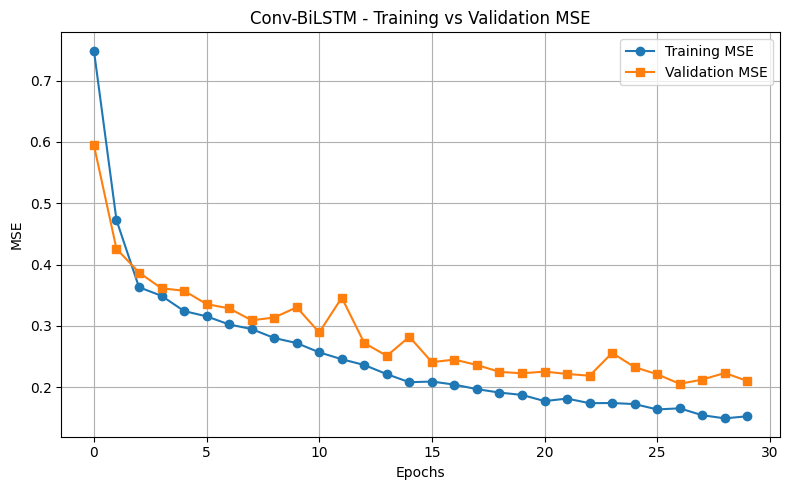

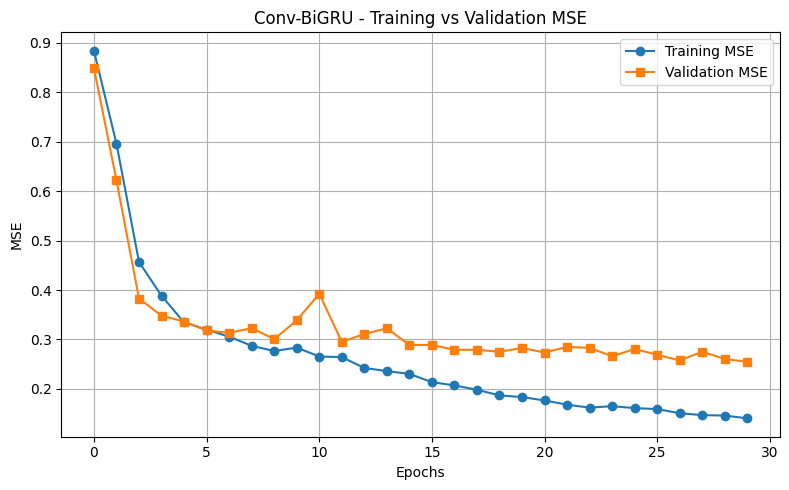

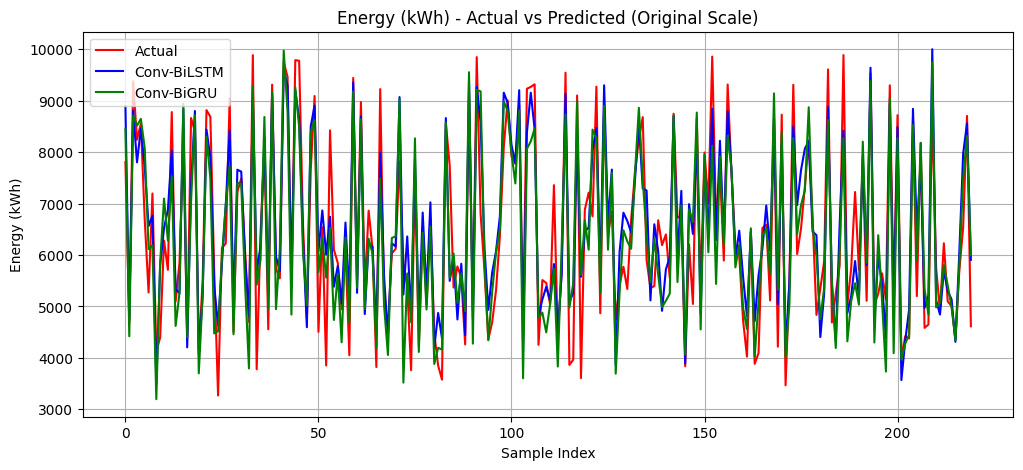

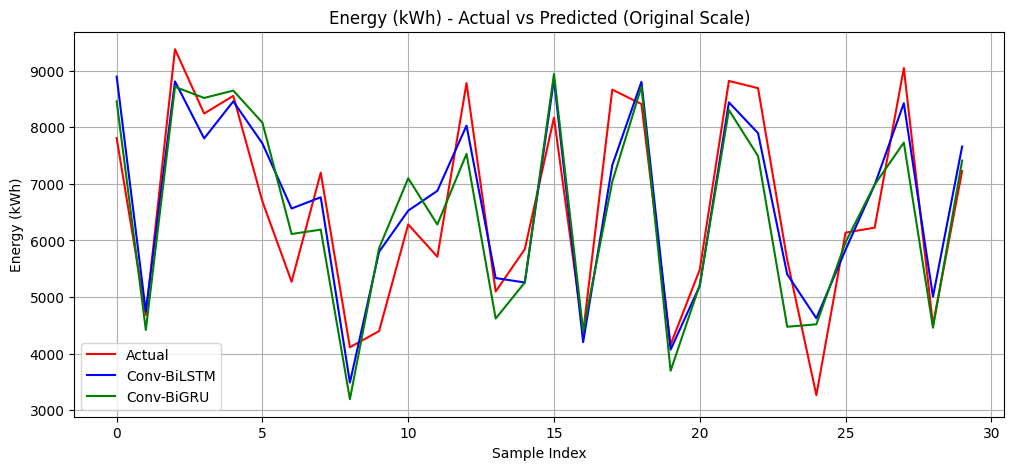

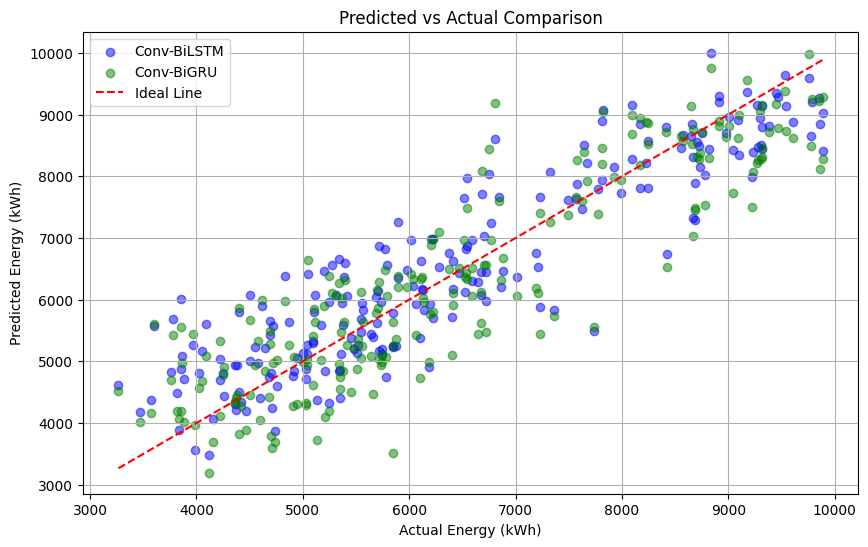

In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
from math import sqrt

# Load dataset
df = pd.read_csv("Dundee_Cleaned_WithSeaWeekend.csv")

# Define columns
categorical_cols = ['Site', 'CP ID', 'Connector Type', 'Connector', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Duration_hours']
target_col = 'Consum(kWh)'

# Label encode categorical columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Apply StandardScaler to numerical columns + target
scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Split into X and y
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values

# Sequence creation
def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)

# Train-test split
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

# Embedding configuration
embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

# Build model
def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(1)(x)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare model input
def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Conv-BiLSTM
model_bilstm = build_model('lstm')
history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Conv-BiGRU
model_bigru = build_model('gru')
history_bigru = model_bigru.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                validation_split=0.1,callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predict
y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru = model_bigru.predict(test_inputs).flatten()

# Inverse transform predictions to original scale
def inverse_transform(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    return scaler.inverse_transform(combined)[:, -1]

y_test_orig = inverse_transform(y_test)
y_pred_bilstm_orig = inverse_transform(y_pred_bilstm)
y_pred_bigru_orig = inverse_transform(y_pred_bigru)

# Evaluation Function
def evaluate_model(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

    print(f"\n{name} Performance (Original Scale):")
    print(f"  MSE : {mean_squared_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  MAE : {mean_absolute_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_test_orig, inverse_transform(y_pred))):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_test_orig, inverse_transform(y_pred)) * 100:.6f}")
    print(f"  R²  : {r2_score(y_test_orig, inverse_transform(y_pred)):.6f}")

evaluate_model(y_test, y_pred_bilstm, "Conv-BiLSTM")
evaluate_model(y_test, y_pred_bigru, "Conv-BiGRU")

# Visualization
def plot_training_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title("Energy (kWh) - Actual vs Predicted (Original Scale)")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curve(history_bilstm, "Conv-BiLSTM")
plot_training_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, 1000, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4376 - mae: 0.5154
Epoch 1: val_loss improved from inf to 0.17409, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.4342 - mae: 0.5131 - val_loss: 0.1741 - val_mae: 0.3326
Epoch 2/50
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2747 - mae: 0.3831
Epoch 2: val_loss improved from 0.17409 to 0.17320, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2732 - mae: 0.3842 - val_loss: 0.1732 - val_mae: 0.3358
Epoch 3/50
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2320 - mae: 0.3723
Epoch 3: val_loss did not improve from 0.17320
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2339 - mae: 0.3732 - val_loss: 0.1892 - val_mae: 0.3638
Epoch 4/50
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2471 - mae: 0.3932
Epoch 4: val_loss improved from 0.17320 to 0.15041, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2453 - mae

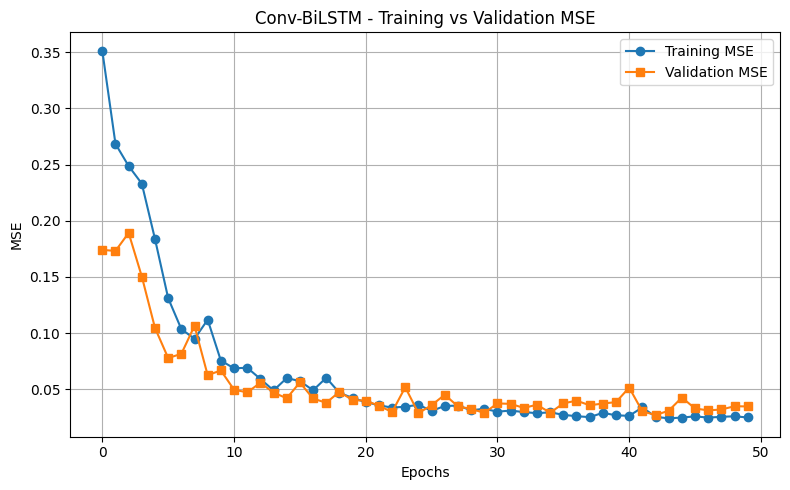

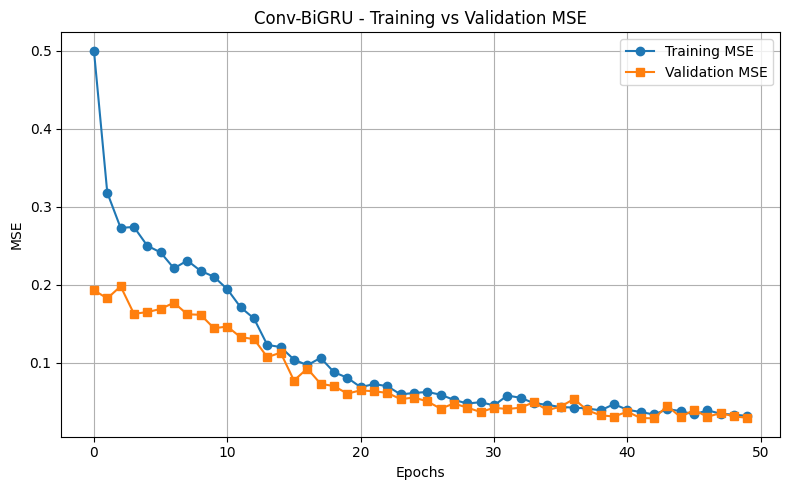

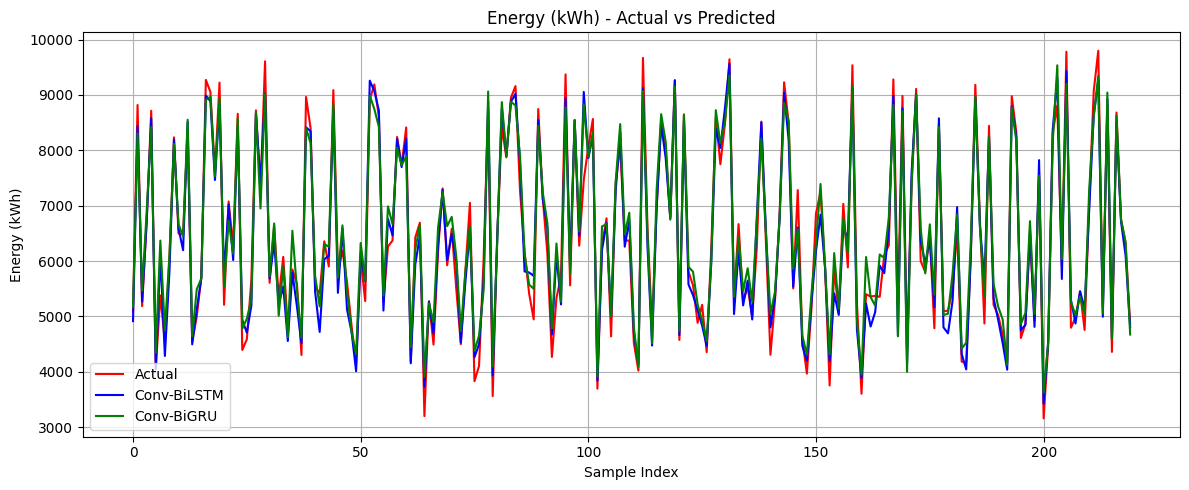

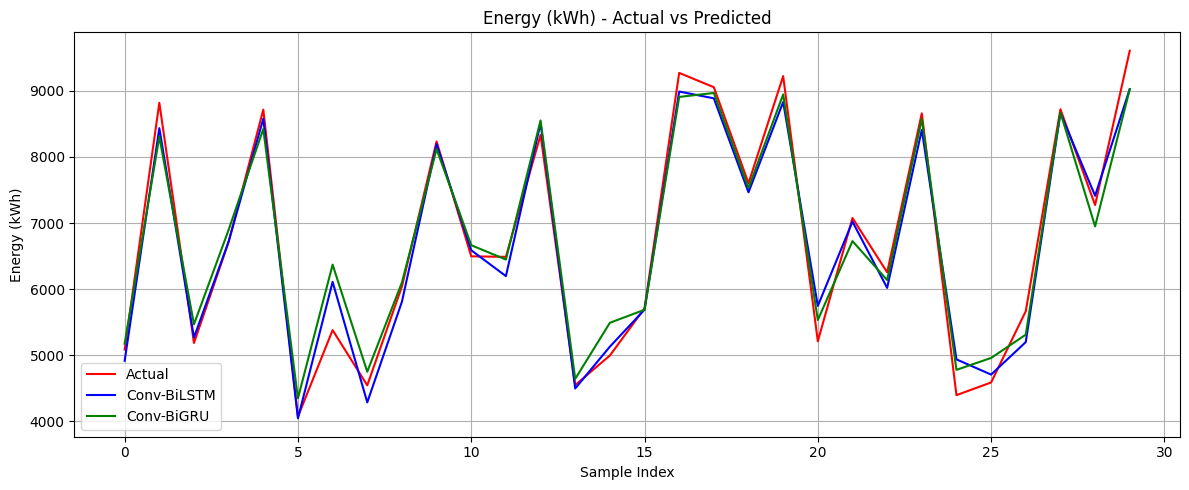

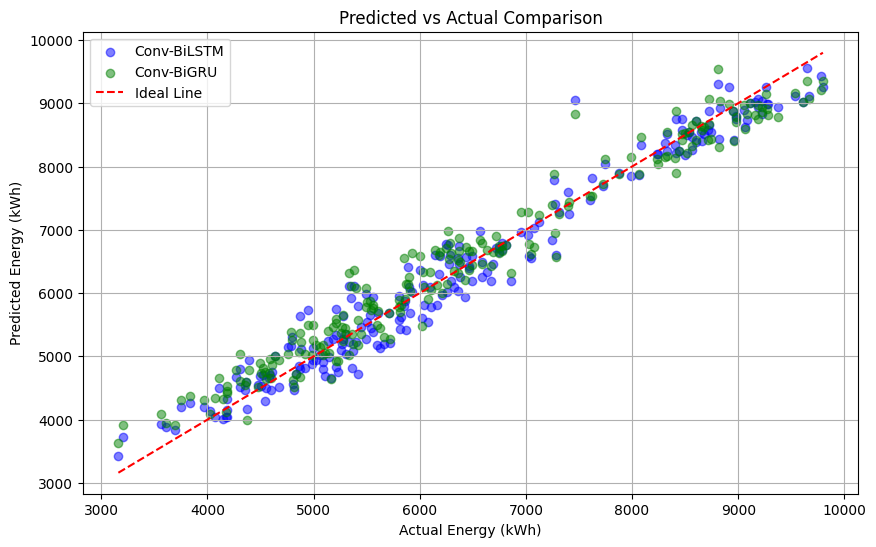

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os

# ✅ Load updated dataset
df = pd.read_csv("Dundee_Cleaned_WithSeaWeekend.csv")

# ✅ Updated preprocessing WITHOUT log
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Consum(kWh)'].shift(lag)
df['rolling_mean_3'] = df['Consum(kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Consum(kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Consum(kWh)'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# ✅ Updated columns
categorical_cols = ['Site', 'CP ID', 'Connector Type', 'Connector', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Duration_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# ✅ Updated scaling
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

# ✅ Prepare inputs
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = 128
    conv_kernel = 1
    activation_fn = 'selu'
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    if rnn_type == 'lstm':
        rnn_units = 128
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn_units = 80
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model_bilstm = build_model('lstm')
model_bigru = build_model('gru')

checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title(f"Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters and GA for time steps selection

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
7/7 ━━━

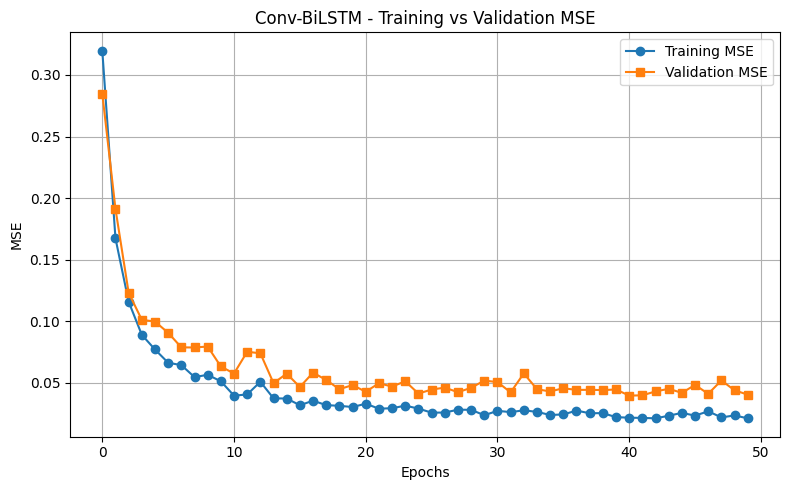

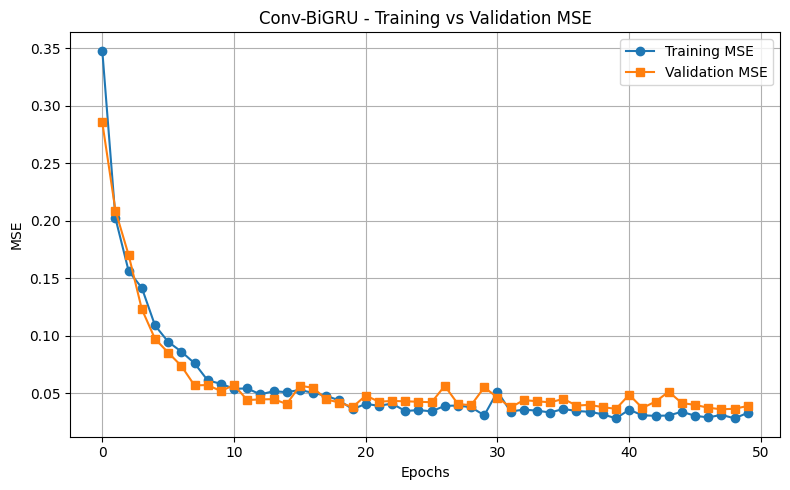

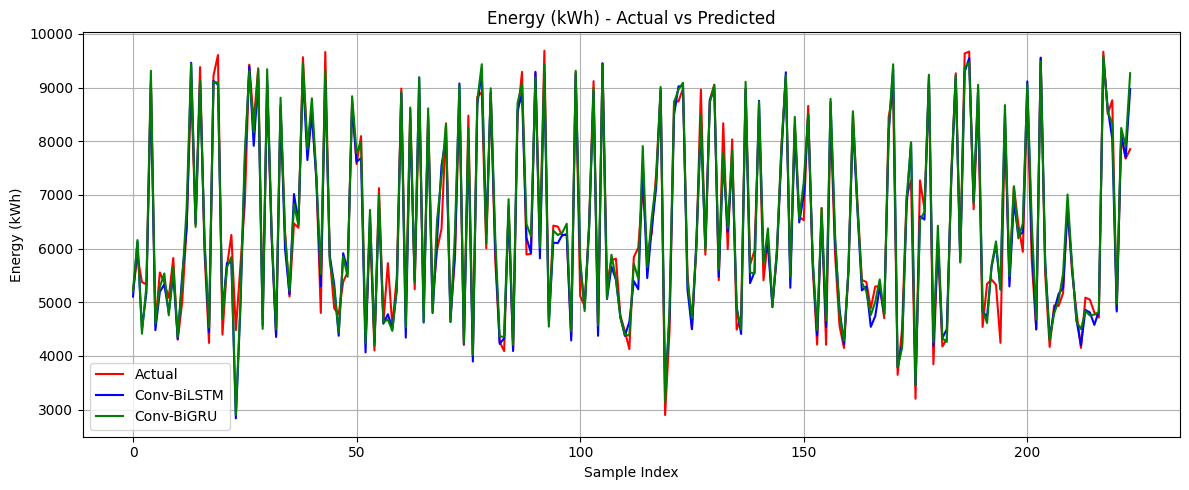

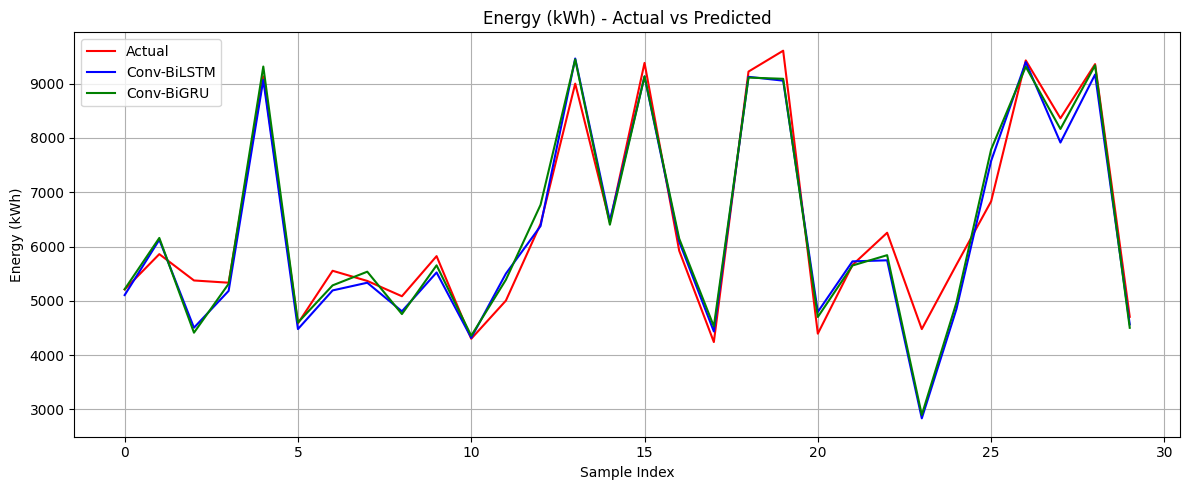

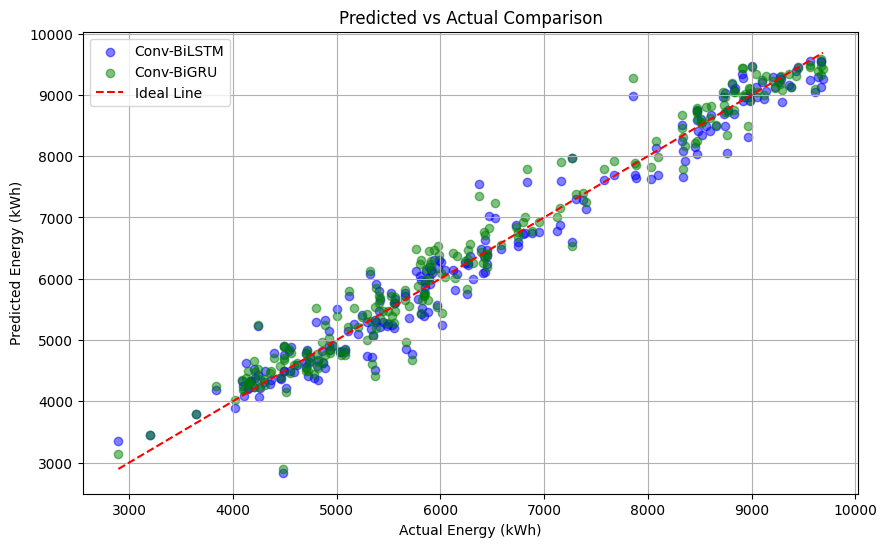

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os
import pygad

# ✅ Load dataset
df = pd.read_csv("Dundee_Cleaned_WithSeaWeekend.csv")

# ✅ Preprocessing
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Consum(kWh)'].shift(lag)
df['rolling_mean_3'] = df['Consum(kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Consum(kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Consum(kWh)'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

categorical_cols = ['Site', 'CP ID', 'Connector Type', 'Connector', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Duration_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def create_sequences(X_cat, X_num, y, time_steps):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type, time_steps):
    cat_inputs = [Input(shape=(time_steps,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(time_steps, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = 128
    conv_kernel = 1
    activation_fn = 'selu'
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    if rnn_type == 'lstm':
        rnn_units = 128
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn_units = 80
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ✅ GA fitness function
def fitness_func(ga_instance, solution, solution_idx):
    time_steps = int(solution[0])
    X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y, time_steps)
    X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
        X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

    train_inputs = prepare_input(X_cat_train, X_num_train)
    test_inputs = prepare_input(X_cat_test, X_num_test)

    model_bilstm = build_model('lstm', time_steps)
    model_bigru = build_model('gru', time_steps)

    model_bilstm.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    model_bigru.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

    y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
    y_pred_bigru = model_bigru.predict(test_inputs).flatten()

    mse_bilstm = mean_squared_error(y_test, y_pred_bilstm)
    mse_bigru = mean_squared_error(y_test, y_pred_bigru)
    avg_mse = (mse_bilstm + mse_bigru) / 2

    return -avg_mse  # GA maximizes

# ✅ Run GA
ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=2,
    fitness_func=fitness_func,
    sol_per_pop=5,
    num_genes=1,
    gene_type=int,
    init_range_low=7,
    init_range_high=90,
    gene_space={'low': 7, 'high': 90, 'step': 1},
    mutation_percent_genes=100,
    mutation_type="random"
)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
best_time_step = int(solution[0])
print(f"\n✅ Best time_steps found: {best_time_step} with fitness {solution_fitness:.6f}")

# ✅ Final training
X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y, best_time_step)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

model_bilstm = build_model('lstm', best_time_step)
model_bigru = build_model('gru', best_time_step)

checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title(f"Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Peak Day Prediction using 7 day forecast

Epoch 1/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7846
Epoch 1: val_loss improved from inf to 0.23019, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7449 - val_loss: 0.2302
Epoch 2/100
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2636
Epoch 2: val_loss improved from 0.23019 to 0.21099, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2633 - val_loss: 0.2110
Epoch 3/100
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2437
Epoch 3: val_loss improved from 0.21099 to 0.19348, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2452 - val_loss: 0.1935
Epoch 4/100
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2476
Epoch 4: val_loss improved from 0.19348 to 0.18644, saving model to temp_bilstm.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2415 - val_loss: 0.1864
Epoch 5/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2095
Epoch 5: val_loss did not improve 

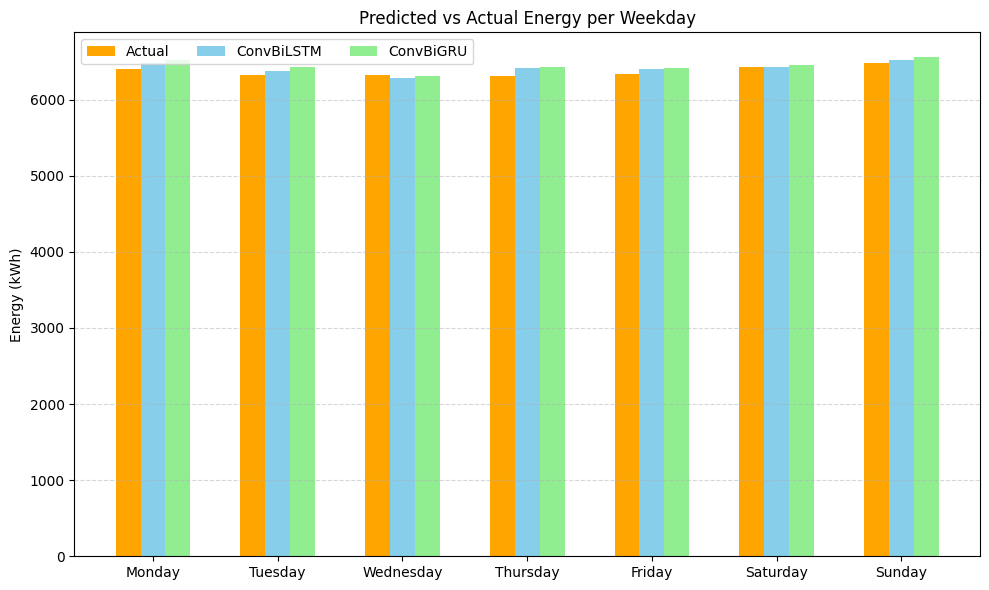

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
import os

# Load dataset
df = pd.read_csv("Dundee_Cleaned_WithSeaWeekend.csv")

for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Consum(kWh)'].shift(lag)
df['rolling_mean_3'] = df['Consum(kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Consum(kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Consum(kWh)'].rolling(window=3, min_periods=1).mean()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Define columns
categorical_cols = ['Site', 'CP ID', 'Connector Type', 'Connector', 'Start_hour', 'End_hour', 'Day_of_week', 'is_weekend', 'season']
numerical_cols = ['Duration_hours', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']
target_col = 'smooth_target'

# Encode and scale
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Sequence data
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values
dow = df['Day_of_week'].values

def create_7day_sequences(X_cat, X_num, y, dow, time_steps=25):
    Xs_cat, Xs_num, ys, dows = [], [], [], []
    for i in range(len(X_cat) - time_steps - 7):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps:i + time_steps + 7])
        dows.append(dow[i + time_steps:i + time_steps + 7])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys), np.array(dows)

X_cat_seq, X_num_seq, y_seq, dow_seq = create_7day_sequences(X_cat, X_num, y, dow)

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test, dow_train, dow_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, dow_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(25,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(25, len(numerical_cols)), name="numerical_input")
    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)
    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(7)(x)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Train Conv-BiLSTM
model_bilstm = build_model('lstm')
model_bilstm.fit(train_inputs, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Train Conv-BiGRU
model_bigru = build_model('gru')
model_bigru.fit(train_inputs, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predict
y_pred_bilstm_scaled = model_bilstm.predict(test_inputs)
y_pred_bigru_scaled = model_bigru.predict(test_inputs)

# Inverse transform predictions
def inverse_transform_7day(predictions):
    restored = []
    for i in range(predictions.shape[1]):
        pad = np.zeros((len(predictions), len(numerical_cols)))
        combined = np.hstack((pad, predictions[:, i:i+1]))
        restored_kwh = scaler.inverse_transform(combined)[:, -1]
        restored.append(restored_kwh)
    return np.stack(restored, axis=1)

y_pred_bilstm_kwh = inverse_transform_7day(y_pred_bilstm_scaled)
y_pred_bigru_kwh = inverse_transform_7day(y_pred_bigru_scaled)

# Aggregate predicted energy by weekday
weekday_energy_bilstm = {i: [] for i in range(7)}
weekday_energy_bigru = {i: [] for i in range(7)}

for i in range(len(dow_test)):
    for d, e1, e2 in zip(dow_test[i], y_pred_bilstm_kwh[i], y_pred_bigru_kwh[i]):
        weekday_energy_bilstm[d].append(e1)
        weekday_energy_bigru[d].append(e2)

# Calculate average and total energy
avg_kwh_bilstm = {d: np.mean(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
avg_kwh_bigru = {d: np.mean(weekday_energy_bigru[d]) for d in weekday_energy_bigru}
total_kwh_bilstm = {d: np.sum(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
total_kwh_bigru = {d: np.sum(weekday_energy_bigru[d]) for d in weekday_energy_bigru}

# Calculate actual average energy per weekday (from the original dataset)
def inverse_transform_actual(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    restored_kwh = scaler.inverse_transform(combined)[:, -1]
    return restored_kwh

df['Actual_Energy'] = inverse_transform_actual(df[target_col].values)

# Now, calculate the average energy per weekday
actual_avg_kwh = {i: np.mean(df[df['Day_of_week'] == i]['Actual_Energy']) for i in range(7)}

# Create readable DataFrame with actual values
df_summary = pd.DataFrame({
    'Weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'Avg_kWh_BiLSTM': [avg_kwh_bilstm[i] for i in range(7)],
    'Avg_kWh_BiGRU': [avg_kwh_bigru[i] for i in range(7)],
    'Actual_Avg_kWh': [actual_avg_kwh[i] for i in range(7)],
    'Total_kWh_BiLSTM': [total_kwh_bilstm[i] for i in range(7)],
    'Total_kWh_BiGRU': [total_kwh_bigru[i] for i in range(7)]
    
})

print("\n📋 Predicted and Actual Energy Summary per Weekday:")
print(df_summary)

# Optional: plot side-by-side average with actual energy values
plt.figure(figsize=(10, 6))
x = np.arange(7)
bar_width = 0.2
plt.bar(x - bar_width, df_summary['Actual_Avg_kWh'], width=bar_width, label='Actual', color='orange')
plt.bar(x, df_summary['Avg_kWh_BiLSTM'], width=bar_width, label='ConvBiLSTM', color='skyblue')
plt.bar(x + bar_width, df_summary['Avg_kWh_BiGRU'], width=bar_width, label='ConvBiGRU', color='lightgreen')
plt.xticks(x, df_summary['Weekday'])
plt.ylabel("Energy (kWh)")
plt.title("Predicted vs Actual Energy per Weekday")
plt.legend(loc='upper left', ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


ConvLSTM-BiLSTM Encoder Decoder

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 3.9555 - mae: 0.8520 - val_loss: 2.7171 - val_mae: 0.7646
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.4281 - mae: 0.7187 - val_loss: 1.7372 - val_mae: 0.6231
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.5594 - mae: 0.5808 - val_loss: 1.2253 - val_mae: 0.5581
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.1003 - mae: 0.5259 - val_loss: 0.9201 - val_mae: 0.5155
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8405 - mae: 0.4921 - val_loss: 0.6736 - val_mae: 0.4411
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.6613 - mae: 0.4482 - val_loss: 0.5864 - val_mae: 0.4223
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.5842 - mae: 0.4292 - val_loss: 0.5397 - val_mae: 0.4190
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.5575 - mae: 0.4414 - val_loss: 0.5054 - val_mae: 0.4111
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.49

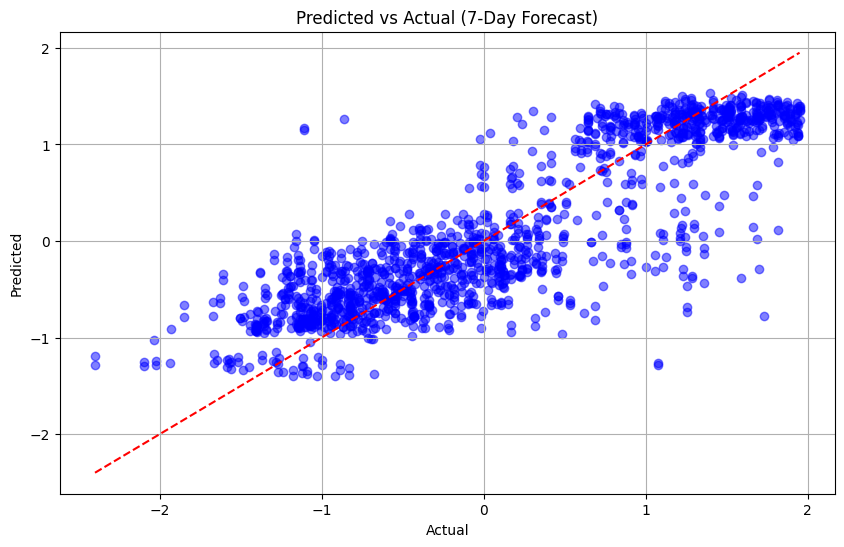

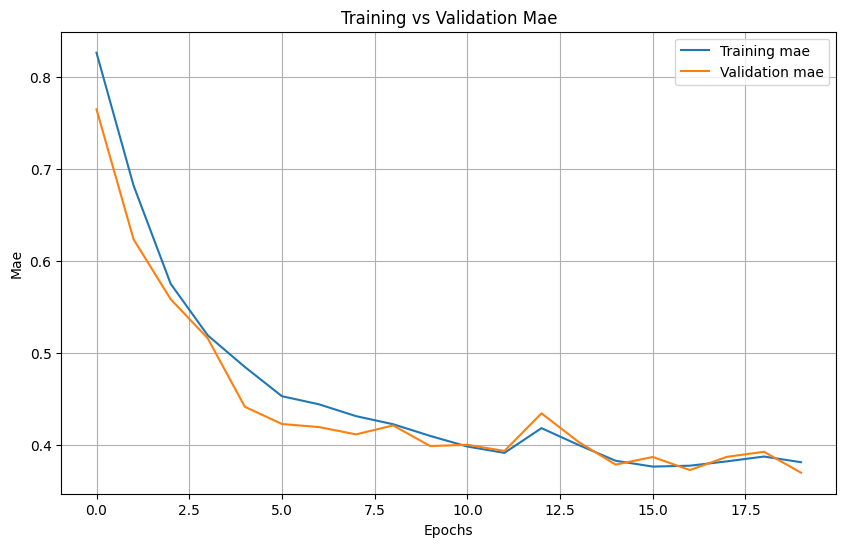

In [6]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, Bidirectional, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# 2. Load Dataset
df = pd.read_csv("Dundee_Cleaned_WithSeaWeekend.csv")

# 3. Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 4. Feature & Target Separation
features = df.drop(columns=['Consum(kWh)'])
target = df['Consum(kWh)']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # shape = (time, rows=1, cols=n_features, channels=1)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build ConvLSTM → BiLSTM Model
def build_conv_bilstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False)(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_conv_bilstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Predict and Reshape Output
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)
y_true = y_test

# 11. Evaluation Metrics
def evaluate_model(y_true, y_pred, name="ConvLSTM-BiLSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance (7-Day Forecast):")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_true, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='blue')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


ConvBiLSTM-LSTM encoder-decoder

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 2.0146 - mae: 0.8344 - val_loss: 2.8700 - val_mae: 0.8169
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.8408 - mae: 0.8971 - val_loss: 1.2308 - val_mae: 0.7160
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.1559 - mae: 0.6861 - val_loss: 1.0197 - val_mae: 0.6429
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.9854 - mae: 0.6375 - val_loss: 0.8925 - val_mae: 0.5991
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.8745 - mae: 0.5941 - val_loss: 0.8616 - val_mae: 0.5963
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.8119 - mae: 0.5716 - val_loss: 0.7354 - val_mae: 0.5243
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7355 - mae: 0.5271 - val_loss: 0.6683 - val_mae: 0.4857
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.6748 - mae: 0.4947 - val_loss: 0.6163 - val_mae: 0.4451
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.64

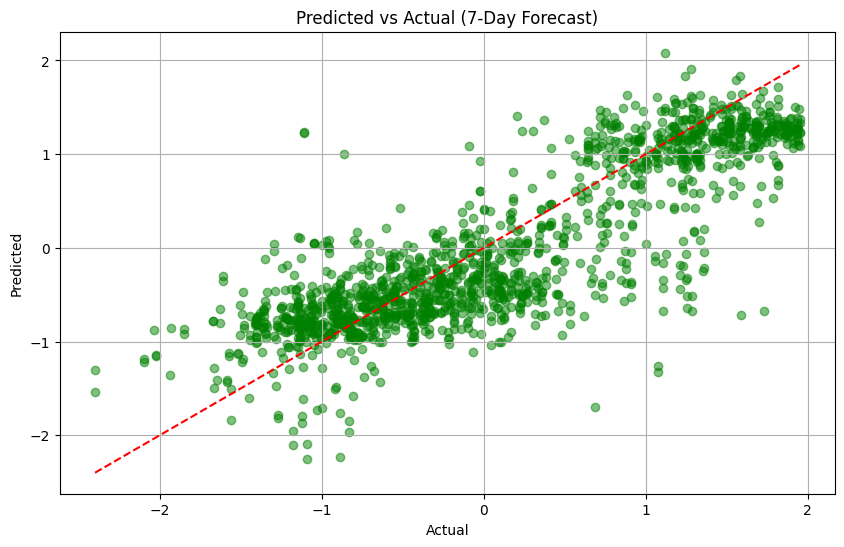

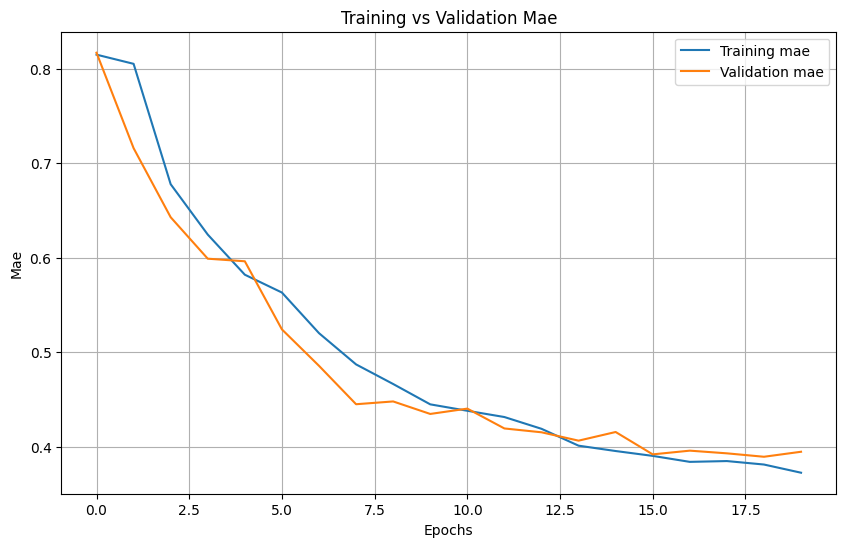

In [4]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# 2. Load Dataset
df = pd.read_csv("Dundee_Cleaned_WithSeaWeekend.csv")

# 3. Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 4. Feature & Target Separation
features = df.drop(columns=['Consum(kWh)'])
target = df['Consum(kWh)']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # (t, rows, cols, ch)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build BiConvLSTM → LSTM Model
def build_biconvlstm_lstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False))(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_biconvlstm_lstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Prediction
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)

# 11. Evaluation
def evaluate_model(y_true, y_pred, name="BiConvLSTM-LSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_test, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='green')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


C:\Users\user\AppData\Local\Temp\ipykernel_25340\84526144.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.rename(columns={'Duration_hours': 'Charge_time', 'Consum(kWh)': 'Energy'}, inplace=True)


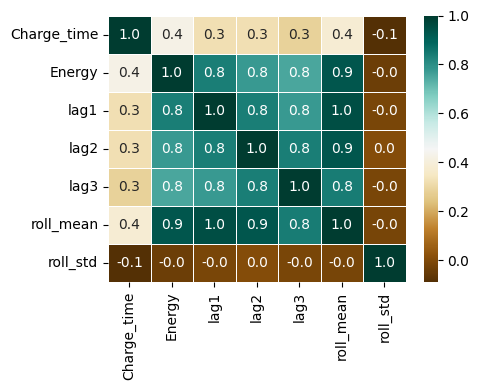

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Dundee_Cleaned_WithSeaWeekend.csv')

# Ensure the data is sorted by date if necessary
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')

# Create lag features
df['lag1'] = df['Consum(kWh)'].shift(1)
df['lag2'] = df['Consum(kWh)'].shift(2)
df['lag3'] = df['Consum(kWh)'].shift(3)

# Create rolling features (window=3, center=False)
df['roll_mean'] = df['Consum(kWh)'].rolling(window=3).mean()
df['roll_std'] = df['Consum(kWh)'].rolling(window=3).std()

# Select relevant columns
selected_columns = [
    'Duration_hours', 'Consum(kWh)',
    'lag1', 'lag2', 'lag3', 'roll_mean', 'roll_std'
]
selected_df = df[selected_columns]
selected_df.rename(columns={'Duration_hours': 'Charge_time', 'Consum(kWh)': 'Energy'}, inplace=True)

# Drop rows with NaN from lag/rolling calculation
selected_df = selected_df.dropna()

# Compute correlation matrix
correlation_matrix = selected_df.corr()

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='BrBG', linewidths=0.5)
#plt.title('Correlation Heatmap: Dundee')
plt.tight_layout()
plt.show()
